# Model Evaluation
### Linked scatterplots of model residuals, with value counts and average error scores for sub groups
### Tornado plot of feature importances

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

from ipywidgets import interact, fixed

import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft
import model_eval_tools as met
import munge_williston_data as mwd


In [7]:
#specify columns for plotting
ip_day =  180
target_col = f"production_liquid_{ip_day}"
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_units ="bbls"
cat_cols = ["original_operator", "countyname", "stimulated_formation"]
cat_col = cat_cols[2]
tooltip_features = ["currentwellname", cat_col]

In [8]:
foi = ['currentwellname',
       'originaloperator',
       'tvd',
       'length',
       'prop_per_ft',
       'fluid_per_ft',
       'stage_spacing',
       'countyname',
       'stimulated_formation']

In [9]:
inspect_df = (pd.read_csv("../data/cleaned-input.test.tsv", sep="\t").copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: mwd.haversine_distance(x["surface_lat"], 
                                                                      x["surface_lng"], 
                                                                      x["bh_lat"], 
                                                                      x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              range_tvd=lambda x: x["max_tvd"] - x["min_tvd"],
#                               frac_year=lambda x: x["spud_date"].apply(lambda x: int(x.split("-")[0]))
                             )
                      .filter(foi + coord_cols)
                      .pipe(dmt.reduce_cardinality, cols=['originaloperator', 'countyname'])
                      .assign(original_operator=lambda x: x["originaloperator"].str[:7])
                      .drop("originaloperator", axis=1)
             )

In [10]:
inspect_df.head()

,currentwellname,tvd,length,prop_per_ft,fluid_per_ft,stage_spacing,countyname,stimulated_formation,surface_lat,surface_lng,bh_lat,bh_lng,original_operator
api,,,,,,,,,,,,,
33023010680000,WRITING ROCK 161-101-30-31H-1,8756.79,6164.121839,438.359278,9.437841,0.004056,DIVIDE,bakken,48.748656,-103.845225,48.731764,-103.845153,OTHER
33061019000000,JORGENSEN 11-27H,9830.13,9150.565861,204.013613,2.971073,0.002841,MOUNTRAIL,bakken,48.137685,-102.370201,48.136892,-102.332644,WHITING
33053051430000,MOBERG FEDERAL 149-95-29-32-11H,11023.77,9926.803859,166.361703,1.624793,0.003224,MCKENZIE,three forks,47.701894,-102.869198,47.674747,-102.871779,OTHER
33053045070000,CIRRUS 149-94-33D-28H,11068.31,10054.434942,648.031445,4.690567,0.002288,MCKENZIE,bakken,47.674779,-102.709854,47.702324,-102.708901,OTHER
33053047660000,SMOKEY 3-17-20-14H,11190.58,2785.099194,1526.693200,34.530547,0.011849,MCKENZIE,bakken,47.731386,-103.253209,47.723891,-103.251070,OTHER


In [11]:
eval_df = (pd.read_csv("../results/eval_df.tsv", sep="\t", dtype={"api": "O"})
                 .set_index("api")
                 .join(inspect_df)
                 .assign(day=ip_day,
                         prod_rate=lambda x: x["actual"] / x["day"]
                        )
          )

In [12]:
eval_df.columns

Index(['actual', 'pred', 'resid', 'perc_resid', 'abs_resid', 'abs_perc_resid',
       'currentwellname', 'tvd', 'length', 'prop_per_ft', 'fluid_per_ft',
       'stage_spacing', 'countyname', 'stimulated_formation', 'surface_lat',
       'surface_lng', 'bh_lat', 'bh_lng', 'original_operator', 'day',
       'prod_rate'],
      dtype='object')

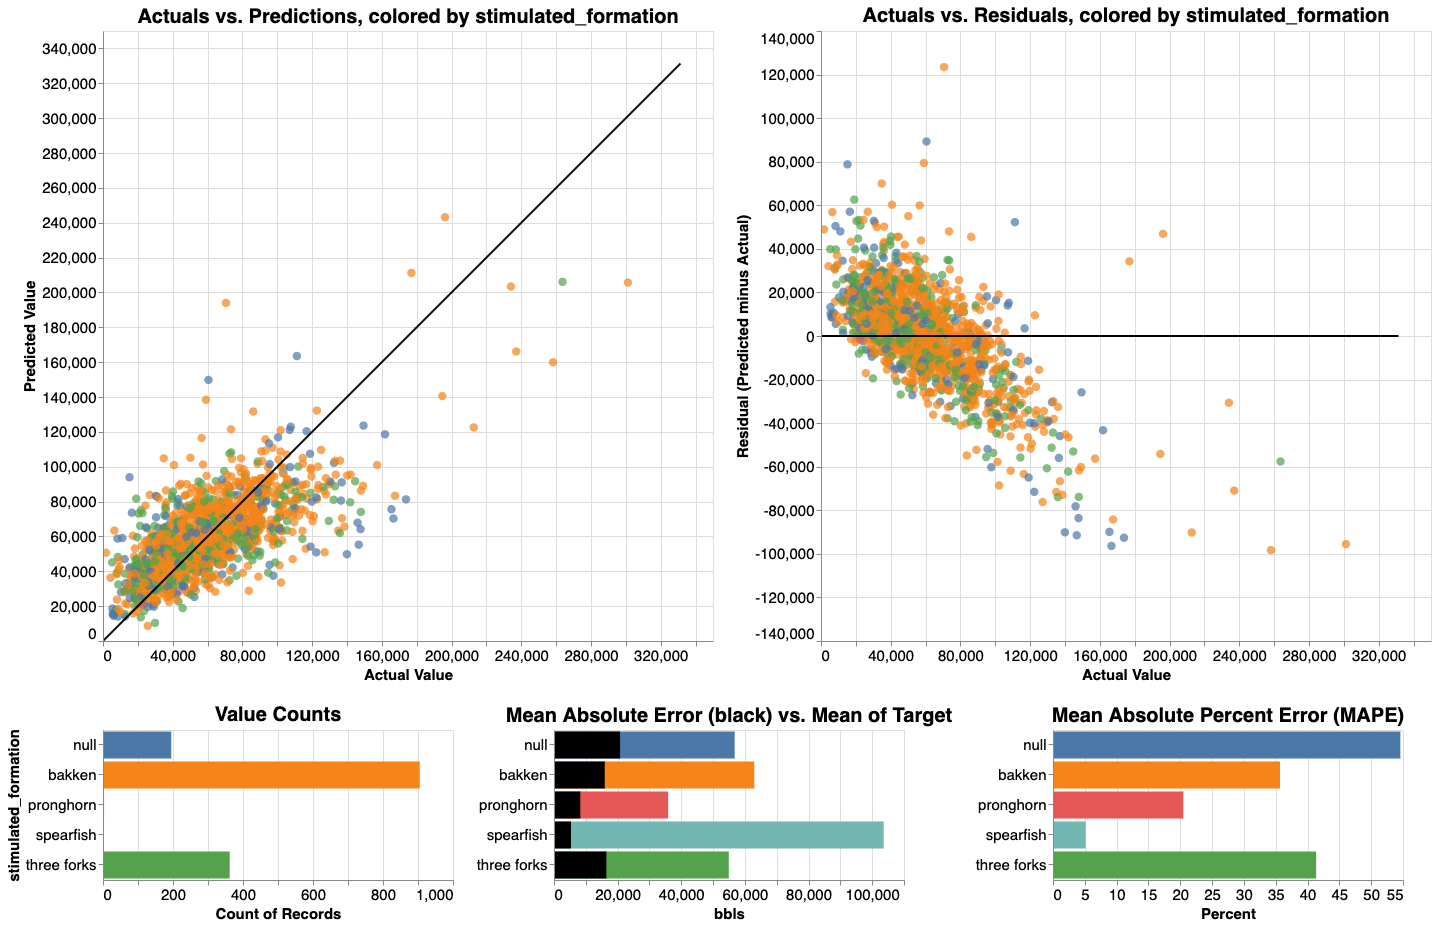

In [13]:
met.draw_resid_dashboard(eval_df, target_units, cat_col="stimulated_formation", tooltip_features=tooltip_features)

In [14]:
interact(met.draw_resid_dashboard, resids_df=fixed(eval_df), cat_col=cat_cols, tooltip_features=fixed(tooltip_features), target_units=fixed(target_units))

interactive(children=(Dropdown(description='cat_col', options=('original_operator', 'countyname', 'stimulated_…

<function model_eval_tools.draw_resid_dashboard(resids_df, target_units, cat_col, tooltip_features)>

# Feature Importances

In [15]:
feat_imp_df = pd.read_csv("../results/feat_imp_df.tsv", sep="\t")

In [16]:
feat_imp_df

,feature,importance
0,total_lbs_proppant,0.262787
1,shortest_dist,0.141754
2,tvd,0.098354
3,bakken_isopach_ft,0.084106
4,mean_tvd,0.083192
5,total_volume_bbls,0.081301
6,length,0.068820
7,total_num_stages,0.059132
8,std_tvd,0.053684
9,stage_spacing,0.050388


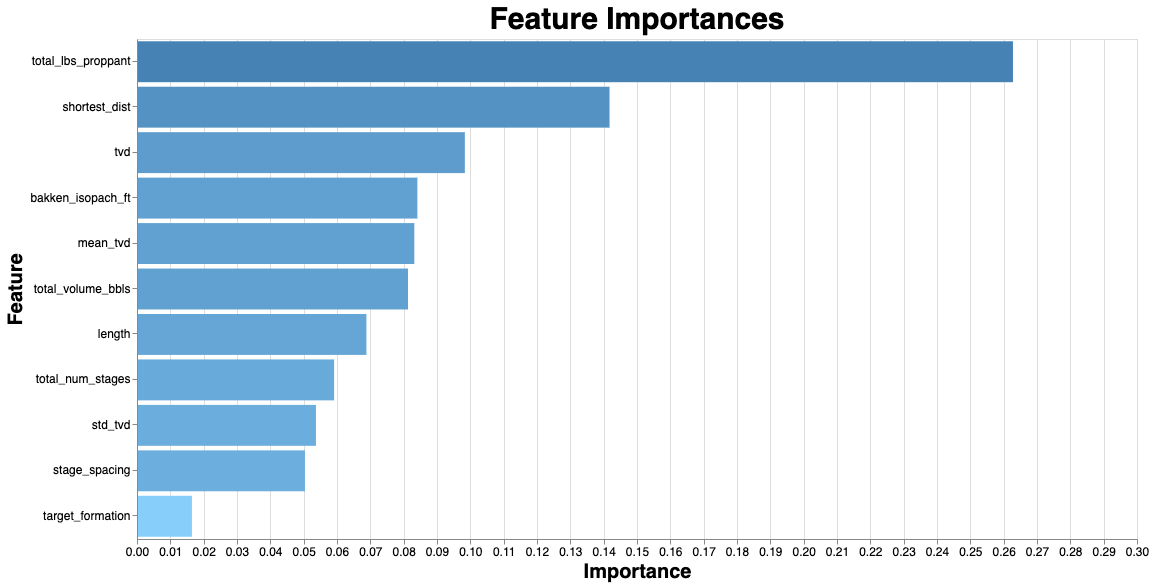

In [17]:
met.draw_feature_importance_tornado(feat_imp_df)

In [18]:
eval_df.abs_resid.mean()

16688.592708049113

### TODO
- [ ] Residuals and Absolute Percent Residuals on a map (with heatmap)
- [ ] Add new plot to examine residuals against continuous variables.